In [235]:
import numpy as np
import pandas as pd
from pathlib import Path

In [236]:
data_folder = Path('./data')

In [237]:
classes = list(data_folder.iterdir())
classes

[PosixPath('data/running'),
 PosixPath('data/stairs'),
 PosixPath('data/walking'),
 PosixPath('data/idle')]

In [238]:
dfs = []
def flatten_sensor_frame(df): return df.values.flatten()
data_list = []
for class_folder in classes:
    for file in class_folder.iterdir():
        df = pd.read_csv(file)

        frame = flatten_sensor_frame(df)
        record = list((frame)) + [str(class_folder)]
        data_list.append(record)
        
        df['label'] = class_folder
        dfs.append(df)

    
cols = [str(i) for i in range(90)] + ['label']
full_df = pd.DataFrame(data=data_list, columns=cols)

In [239]:
concated = pd.concat(dfs)

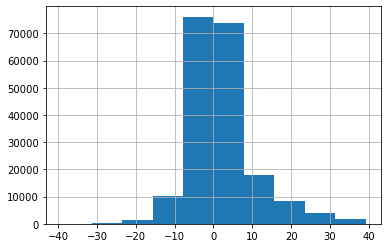

In [240]:
concated['accelerometer_X'].hist()

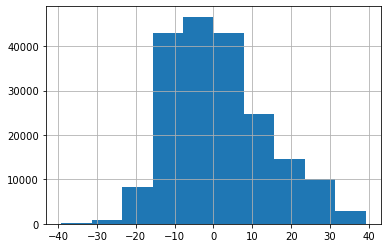

In [241]:
concated['accelerometer_Y'].hist()

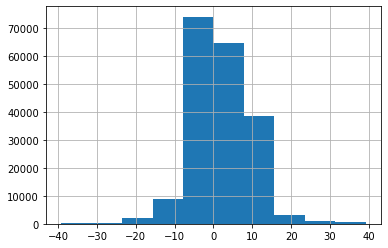

In [242]:
concated['accelerometer_Z'].hist()

In [243]:
full_df.shape

(6462, 91)

In [244]:
full_df['label'].value_counts()

data/running    3408
data/walking    1850
data/idle       1039
data/stairs      165
Name: label, dtype: int64

# Split

In [245]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [246]:
stairs_df = full_df[full_df['label'].isin(['data/walking', 'data/stairs'])]

In [247]:
X_stairs = full_df[[str(i) for i in range(90)] ]
y_stairs = full_df['label'] == 'data/walking'

In [248]:
y_stairs.value_counts()

False    4612
True     1850
Name: label, dtype: int64

In [249]:
label2num = dict(enumerate(full_df['label'].unique()))
label2num

{0: 'data/running', 1: 'data/stairs', 2: 'data/walking', 3: 'data/idle'}

In [250]:
num2label = {n:i for i,n in label2num.items()}
num2label

{'data/running': 0, 'data/stairs': 1, 'data/walking': 2, 'data/idle': 3}

In [251]:
X = full_df[[str(i) for i in range(90)] ]
y = full_df['label'].map(num2label)

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# SVM

In [253]:
from sklearn.preprocessing import StandardScaler

In [254]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [255]:
from sklearn import svm

In [256]:
clf = svm.SVC()

In [257]:
clf.fit(X_train_scaled, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [258]:
y_pred = clf.predict(X_test_scaled)

In [259]:
accuracy_score(y_pred, y_test)

0.9826535396155649

In [260]:
confusion_matrix(y_test, y_pred)

array([[1144,    0,    0,    0],
       [   0,   18,   37,    0],
       [   0,    0,  600,    0],
       [   0,    0,    0,  334]])

## linear

In [270]:
lin_clf = svm.SVC(kernel='linear')

In [271]:
lin_clf.fit(X_train_scaled, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [272]:
y_pred = lin_clf.predict(X_test_scaled)

In [273]:
accuracy_score(y_pred, y_test)

0.9732770745428974

In [274]:
confusion_matrix(y_test, y_pred)

array([[1138,    0,    0,    6],
       [   0,   19,   36,    0],
       [   0,   15,  585,    0],
       [   0,    0,    0,  334]])

In [279]:
lin_clf.coef_.shape

(6, 90)

In [280]:
lin_clf = svm.LinearSVC()

In [281]:
lin_clf.fit(X_train_scaled, y_train)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [282]:
y_pred = lin_clf.predict(X_test_scaled)

In [283]:
accuracy_score(y_pred, y_test)

0.9756211908110642

In [284]:
confusion_matrix(y_test, y_pred)

array([[1136,    0,    0,    8],
       [   1,   12,   42,    0],
       [   0,    1,  599,    0],
       [   0,    0,    0,  334]])

In [286]:
lin_clf.coef_.shape

(4, 90)

# NN

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

torch.__version__

'1.6.0'

In [76]:
train_ds = TensorDataset(torch.tensor(X_train_scaled).float(), torch.tensor(y_train.values).long())

X_test_tensor = torch.tensor(X_test_scaled).float()
y_test_tensor = torch.tensor(y_test.values).float()

In [77]:
bs = 64

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

In [91]:
in_size = 90
hidden_size = 120
out_size = 4

model = nn.Sequential(
    nn.Linear(in_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, out_size)
)

In [97]:
def check_quality(model, verbose=True):
    with torch.no_grad():
        y_pred = model(X_test_tensor).argmax(dim=1)
        acc = accuracy_score(y_test, y_pred)
        if verbose:
            print(f'Accuracy: {acc}')
        cmat = confusion_matrix(y_test, y_pred)
        return acc, cmat
    
check_quality(model)

Accuracy: 0.972808251289264


(0.972808251289264,
 array([[1141,    0,    0,    3],
        [   0,    0,   55,    0],
        [   0,    0,  600,    0],
        [   0,    0,    0,  334]]))

In [98]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [99]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, (X_batch, y_batch) in enumerate(train_dl, 0):


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        
        if i % 200 == 0:    # print every 2000 mini-batches
            acc, cmatrix = check_quality(model)
            
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

Accuracy: 0.972808251289264
[1,     1] loss: 0.000
Accuracy: 0.972808251289264
[2,     1] loss: 0.000


In [100]:
check_quality(model)

Accuracy: 0.972808251289264


(0.972808251289264,
 array([[1141,    0,    0,    3],
        [   0,    0,   55,    0],
        [   0,    0,  600,    0],
        [   0,    0,    0,  334]]))

In [101]:
for epoch in range(6):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, (X_batch, y_batch) in enumerate(train_dl, 0):


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 0:    # print every 2000 mini-batches
            acc, cmatrix = check_quality(model)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

Accuracy: 0.972808251289264
[1,     1] loss: 0.000
Accuracy: 0.972808251289264
[2,     1] loss: 0.000
Accuracy: 0.972808251289264
[3,     1] loss: 0.000
Accuracy: 0.972808251289264
[4,     1] loss: 0.000
Accuracy: 0.972808251289264
[5,     1] loss: 0.000
Accuracy: 0.972808251289264
[6,     1] loss: 0.000


In [102]:
check_quality(model)

Accuracy: 0.972808251289264


(0.972808251289264,
 array([[1141,    0,    0,    3],
        [   0,    0,   55,    0],
        [   0,    0,  600,    0],
        [   0,    0,    0,  334]]))

# Conv1D

In [287]:
conv1 = nn.Conv1d(3, 1, 12)

In [288]:
sample_input = torch.rand((300, 3, 30))
conv1(sample_input).shape

torch.Size([300, 1, 19])

In [289]:
X_2d = []
def flatten_sensor_frame(df): return df.values.flatten()
data_list = []
for class_folder in classes:
    for file in class_folder.iterdir():
        df = pd.read_csv(file)        
        X_2d.append(df.values)

torch.Size([6462, 3, 30])

In [290]:
X_2d = torch.tensor(X_2d).float()
# y    = concated['label'].values

In [291]:
X_2d.shape, y.shape

(torch.Size([6462, 30, 3]), (6462,))

In [292]:
X_2d = X_2d.reshape(-1, 3, 30)

In [293]:
X_train_2d, X_test_2d, y_train, y_test = train_test_split(X_2d, y, test_size=0.33, random_state=42)

In [294]:
means = X_train_2d.mean(dim=[0,2], keepdims=True)
stds = X_train_2d.std(dim=[0,2], keepdims=True)

In [295]:
X_train_2d = (X_train_2d-means)/stds
X_test_2d = (X_test_2d-means)/stds

In [486]:
X_train_2d = X_train_2d.reshape(-1, 1, 3, 30)
X_test_2d = X_test_2d.reshape(-1, 1, 3, 30)


In [503]:
in_size = 90
hidden_size = 19
out_size = 4


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(3, 1, 12)
        self.fc1 = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        x = (F.relu(self.conv1(x)).reshape(-1, 19))
        x = (self.fc1(x))
        return x
    
model=nn.Sequential(
    nn.Conv2d(1, 6, 3,3),
    nn.ReLU(),
    nn.Conv2d(6,4,1,3),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(out_size*4, out_size)
)

In [504]:
def check_quality(model, verbose=True):
    with torch.no_grad():
        y_pred = model(X_test_2d).argmax(dim=-1).squeeze()
        acc = accuracy_score(y_test, y_pred)
        if verbose:
            print(f'Accuracy: {acc}')
        cmat = confusion_matrix(y_test, y_pred)
        return acc, cmat

check_quality(model)

Accuracy: 0.2653539615564932


(0.2653539615564932,
 array([[   0,    1, 1143,    0],
        [   0,    0,   55,    0],
        [   0,   34,  566,    0],
        [   0,    0,  334,    0]]))

In [505]:
train_ds = TensorDataset((X_train_2d).float(), (y_train).long())

In [506]:
bs = 16

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

In [507]:
model

Sequential(
  (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(3, 3))
  (1): ReLU()
  (2): Conv2d(6, 4, kernel_size=(1, 1), stride=(3, 3))
  (3): ReLU()
  (4): Flatten()
  (5): Linear(in_features=16, out_features=4, bias=True)
)

In [532]:
weight = torch.tensor([1.0, 4.0, 2.0, 1])
criterion = nn.CrossEntropyLoss(weight=weight)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [539]:
bs = 40

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

In [540]:


for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, (X_batch, y_batch) in enumerate(train_dl, 0):


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        
        if i % 2000 == 0:    # print every 2000 mini-batches
            acc, cmatrix = check_quality(model)
            
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

Accuracy: 0.9704641350210971
[1,     1] loss: 0.000
Accuracy: 0.9718706047819972
[2,     1] loss: 0.000
Accuracy: 0.9714017815283638
[3,     1] loss: 0.000
Accuracy: 0.9718706047819972
[4,     1] loss: 0.000
Accuracy: 0.9723394280356306
[5,     1] loss: 0.000


In [541]:
check_quality(model)

Accuracy: 0.972808251289264


(0.972808251289264,
 array([[1140,    0,    0,    4],
        [   0,   21,   34,    0],
        [   0,   20,  580,    0],
        [   0,    0,    0,  334]]))

In [437]:
check_quality(model)

Accuracy: 0.9887482419127989


(0.9887482419127989,
 array([[1142,    0,    0,    2],
        [   0,   43,   12,    0],
        [   0,   10,  590,    0],
        [   0,    0,    0,  334]]))

In [342]:
def check_quality_train(model, verbose=True):
    with torch.no_grad():
        y_pred = model(X_train_2d).argmax(dim=-1).squeeze()
        acc = accuracy_score(y_train, y_pred)
        if verbose:
            print(f'Accuracy: {acc}')
        cmat = confusion_matrix(y_train, y_pred)
        return acc, cmat

In [343]:
check_quality_train(model)

Accuracy: 0.9725109725109725


(0.9725109725109725,
 array([[2257,    0,    0,    7],
        [   0,    0,  110,    0],
        [   0,    2, 1248,    0],
        [   0,    0,    0,  705]]))

# Naive Bayes

In [51]:
from sklearn.naive_bayes import GaussianNB

In [53]:
gnb = GaussianNB()

In [54]:
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [55]:
accuracy_score(y_pred, y_test)

0.9737458977965308

In [56]:
confusion_matrix(y_test, y_pred)

array([[1144,    0,    0,    0],
       [   0,   38,   17,    0],
       [   0,   36,  564,    0],
       [   3,    0,    0,  331]])

# kNN

In [44]:
from sklearn.neighbors import KNeighborsClassifier

In [45]:
neigh = KNeighborsClassifier(n_neighbors=5)

In [46]:
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [47]:
y_pred = neigh.predict(X_test)

In [48]:
accuracy_score(y_pred, y_test)

0.9615564932020628

In [49]:
confusion_matrix(y_test, y_pred)

array([[1113,    0,    0,   31],
       [   0,   45,   10,    0],
       [   0,   41,  559,    0],
       [   0,    0,    0,  334]])

# Random forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
clf = RandomForestClassifier(random_state=0)

In [29]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [31]:
y_pred = clf.predict(X_test)

In [32]:
accuracy_score(y_pred, y_test)

0.9746835443037974

In [33]:
confusion_matrix(y_test, y_pred)

array([[1144,    0,    0,    0],
       [   0,    1,   54,    0],
       [   0,    0,  600,    0],
       [   0,    0,    0,  334]])

In [34]:
y_test.value_counts()

0    1144
2     600
3     334
1      55
Name: label, dtype: int64

In [35]:
pd.Series(y_pred).value_counts()

0    1144
2     654
3     334
1       1
dtype: int64

# lightgbm

In [189]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()


In [190]:
clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [191]:
y_pred = clf.predict(X_test)

In [192]:
accuracy_score(y_pred, y_test)

0.9798406000937646

In [193]:
confusion_matrix(y_test, y_pred)

array([[1144,    0,    0,    0],
       [   0,   13,   42,    0],
       [   0,    1,  599,    0],
       [   0,    0,    0,  334]])

In [72]:
import matplotlib.pyplot as plt

In [74]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [167]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_stairs)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6462 samples in 0.038s...
[t-SNE] Computed neighbors for 6462 samples in 4.490s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6462
[t-SNE] Computed conditional probabilities for sample 2000 / 6462
[t-SNE] Computed conditional probabilities for sample 3000 / 6462
[t-SNE] Computed conditional probabilities for sample 4000 / 6462
[t-SNE] Computed conditional probabilities for sample 5000 / 6462
[t-SNE] Computed conditional probabilities for sample 6000 / 6462
[t-SNE] Computed conditional probabilities for sample 6462 / 6462
[t-SNE] Mean sigma: 0.386747
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.156403
[t-SNE] KL divergence after 300 iterations: 2.483553


In [168]:
tsne_results

array([[-1.7019429 , -1.2364333 ],
       [-9.161739  , -1.0923918 ],
       [-0.74713904, -1.3519472 ],
       ...,
       [ 2.652534  ,  4.0825458 ],
       [ 4.4689126 , 10.391663  ],
       [ 6.2595596 ,  7.523996  ]], dtype=float32)

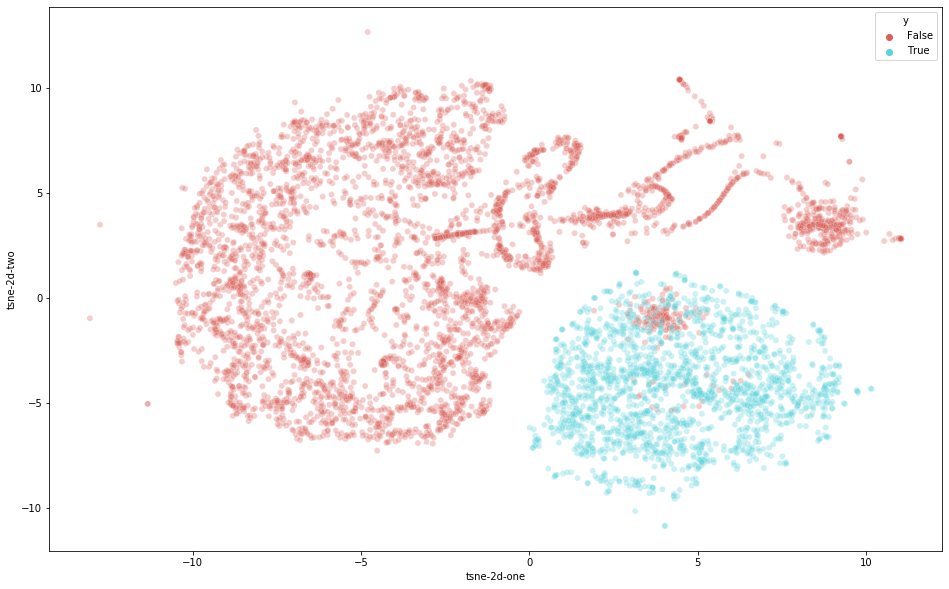

In [170]:
df_subset = pd.DataFrame(columns=['tsne-2d-one', 'tsne-2d-two'])
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['y'] = y_stairs

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3
)

In [81]:
X

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,2.667141,-7.838616,-9.548077,4.017470,8.705317,-2.226607,22.357056,20.887016,-2.820370,17.922995,...,12.430696,-0.885855,11.310209,-8.939949,13.771448,9.825804,1.470040,-2.044648,6.689400,10.807426
1,10.745177,23.415293,1.144428,3.744532,-9.035717,-2.892196,0.766145,21.092916,-0.928950,23.956383,...,0.363919,1.532289,15.782578,1.699883,14.168885,32.245110,3.390190,3.983952,-1.867477,-1.407790
2,22.031445,18.406622,1.537078,3.600880,12.368446,2.217031,-0.354342,-13.206416,-7.254431,8.245631,...,-6.019023,4.151546,24.502260,-1.139640,-0.493206,-14.542381,-2.164358,2.442086,9.677363,-3.016694
3,10.371682,-1.608903,-2.801216,25.718515,16.247053,-6.488286,-3.600879,6.684612,-2.375048,10.534488,...,-5.200206,17.056293,37.330395,5.621586,2.695871,11.626244,-1.082179,8.681376,12.124237,-4.946420
4,3.624822,9.059659,4.390966,33.073500,33.202790,4.802769,3.792416,3.596091,-2.681506,-1.872266,...,-4.079719,1.187524,13.072341,-1.953669,1.441310,-14.585477,3.610456,6.028600,17.889475,-0.732626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6457,0.215478,0.090980,9.734824,0.234632,-0.095768,9.715671,0.239420,-0.009577,9.763555,0.239420,...,9.753978,0.248997,-0.019154,9.749189,0.244209,-0.019154,9.744401,0.234632,-0.004788,9.773131
6458,0.440533,2.360683,9.193734,2.341529,-0.995988,10.515334,-1.728614,-0.387861,10.017340,0.244209,...,9.739613,0.277727,-0.028730,9.768343,0.263362,-0.009577,9.763555,0.248997,-0.004788,9.768343
6459,-1.058237,4.807557,7.824251,-0.866701,4.946421,8.365341,-0.478840,5.152323,8.178593,-0.641646,...,7.196971,-0.656011,6.560113,7.235278,-0.445322,6.464345,7.800309,-0.416591,6.507440,7.091625
6460,-0.114922,-0.105345,9.806650,-0.081403,-0.124498,9.763555,-0.124498,-0.081403,9.840169,-0.081403,...,9.777920,-0.100556,-0.129287,9.777920,-0.081403,-0.124498,9.758766,-0.081403,-0.153229,9.763555


# Try features

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X_stairs, y_stairs, test_size=0.33, random_state=42)

In [172]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [173]:
clf = svm.SVC()

In [174]:
clf.fit(X_train_scaled, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [175]:
y_pred = clf.predict(X_test_scaled)

In [176]:
accuracy_score(y_pred, y_test)

0.974214721050164

In [177]:
confusion_matrix(y_test, y_pred)

array([[1478,   55],
       [   0,  600]])

In [133]:
confusion_matrix(y_test, y_pred)

array([[1143,    0,    0,    1],
       [   0,   19,   36,    0],
       [   0,    2,  598,    0],
       [   0,    0,    0,  334]])

In [116]:
np.array([[1144,    0,    0,    0],
       [   0,   18,   37,    0],
       [   0,    0,  600,    0],
       [   0,    0,    0,  334]])

array([[1144,    0,    0,    0],
       [   0,   18,   37,    0],
       [   0,    0,  600,    0],
       [   0,    0,    0,  334]])

In [95]:
confusion_matrix(y_test, y_pred)

array([[1144,    0,    0,    0],
       [  55,    0,    0,    0],
       [ 600,    0,    0,    0],
       [ 334,    0,    0,    0]])